# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.


In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-17 22:08:56.929091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 22:08:57.257706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training, validation, and test sets) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.


In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).


In [3]:
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
RANDOM_STATE = 2159081 # For reproducibility
MAX_TIME_STEPS = 109  # Define the maximum time steps for your model

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and stored in a dictionary for easy retrieval. The function processes training, validation, and test datasets, and their label counts and examples are printed for verification.


In [4]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)
val_labels = load_labels(LABELS_VAL)
test_labels = load_labels(LABELS_TEST)

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])
print("Number of validation samples:", len(val_labels))
print("Validation example label:", list(val_labels.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])

Number of training samples: 25380
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Number of validation samples: 24844
Validation example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]
Number of testing samples: 71237
Testing example label: [('LA_E_2834763', 'spoof'), ('LA_E_8877452', 'spoof'), ('LA_E_6828287', 'spoof'), ('LA_E_6977360', 'spoof'), ('LA_E_5932896', 'spoof')]


### Section 2.2: Separating Bonafide and Spoof Samples
This section introduces a function to separate bonafide and spoof samples within a dataset. It categorizes labels into two dictionaries, one for each class. The class distribution is printed to assess dataset balance.


In [5]:
# Separate bonafide and spoof samples of a dataset
def separate_bonafide_spoof_samples(dataset_labels):
    bonafide_samples = {k: v for k, v in train_labels.items() if v == 'bonafide'}
    spoof_samples = {k: v for k, v in train_labels.items() if v == 'spoof'}
    return bonafide_samples, spoof_samples

bonafide_train_samples, spoof_train_samples = separate_bonafide_spoof_samples(train_labels)

# Print counts
print(f"Training bonafide samples: {len(bonafide_train_samples)}")
print(f"Training spoof samples: {len(spoof_train_samples)}")

Training bonafide samples: 2580
Training spoof samples: 22800


### Section 2.3: Balancing the Dataset
This section introduces a method to balance the dataset by randomly sampling `spoof` samples to match the count of `bonafide` samples. The balanced dataset is created by combining the two subsets, ensuring class parity for training.


In [6]:
import random
random.seed(RANDOM_STATE)  # For reproducibility

# Balance the dataset by matching the number of spoof samples to bonafide samples
def balance_bonafide_spoof_samples(bonafide_samples, spoof_samples):
    spoof_keys = list(spoof_samples.keys())
    random.shuffle(spoof_keys)
    balanced_spoof_samples = {k: spoof_samples[k] for k in spoof_keys[:len(bonafide_samples)]}

    # Combine bonafide and balanced spoof samples
    balanced_dataset = {**bonafide_samples, **balanced_spoof_samples}

    return balanced_dataset

train_labels_balanced = balance_bonafide_spoof_samples(bonafide_train_samples, spoof_train_samples)

# Print final counts
print(f"Balanced training samples: {len(train_labels_balanced)}")
print("Example label:", list(train_labels_balanced.items())[:5])

Balanced training samples: 5160
Example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]


### Section 2.4 Reduce data for test speed

In [7]:
def shuffle_and_trim_dict(input_dict, n=10000):
    """
    Shuffle the input dictionary and return a new dictionary with the first n elements.

    Args:
        input_dict (dict): The dictionary to shuffle and trim.
        n (int): The number of elements to keep after shuffle. Default is 10,000.

    Returns:
        dict: A shuffled dictionary with up to n elements.
    """
    # Convert dictionary items to a list and shuffle
    items = list(input_dict.items())
    random.shuffle(items)

    # Trim the list to the first n elements and recreate the dictionary
    trimmed_dict = dict(items[:n])

    return trimmed_dict

# ATTENTION: Dataset limiting --------------------------------
val_labels = shuffle_and_trim_dict(val_labels, n=10000)
test_labels = shuffle_and_trim_dict(test_labels, n=10000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training samples:", len(train_labels_balanced))
print("Training example label:", list(train_labels_balanced.items())[:5])
print("Number of validation samples:", len(val_labels))
print("Validation example label:", list(val_labels.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])

Number of training samples: 25380
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Number of validation samples: 10000
Validation example label: [('LA_D_5800896', 'spoof'), ('LA_D_6261315', 'spoof'), ('LA_D_6974451', 'spoof'), ('LA_D_7168411', 'spoof'), ('LA_D_6231894', 'spoof')]
Number of testing samples: 10000
Testing example label: [('LA_E_2015161', 'spoof'), ('LA_E_9472623', 'spoof'), ('LA_E_5329393', 'bonafide'), ('LA_E_8091846', 'spoof'), ('LA_E_6783160', 'spoof')]


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and MEL Spectrogram Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to Mel spectrograms using `librosa`.
  - Standardize their dimensions using padding or trimming to fit a fixed time step (`MAX_TIME_STEPS`).
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [8]:
from tqdm import tqdm

# Function to load audio files and convert them to Mel spectrograms
def load_dataset_files(dataset_path, dataset_labels):
    """
    Loads audio files from a given dataset path, converts them to Mel spectrograms, 
    and ensures all spectrograms have the same size.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.

    Returns:
        X (np.array): Array of Mel spectrograms.
        y (np.array): Array of corresponding labels.
    """
    X = []
    y = []
    
    # Iterate over each file and its label
    for file_name, label in tqdm(dataset_labels.items(), desc="Loading and converting files"):
        file_path = os.path.join(dataset_path, file_name + ".flac")
        
        try:
            # Load audio file with librosa
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            
            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibel scale
            
            # Adjust spectrogram time steps to MAX_TIME_STEPS
            if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
                # Pad if time steps are less than MAX_TIME_STEPS
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
            else:
                # Trim if time steps exceed MAX_TIME_STEPS
                mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]
            
            X.append(mel_spectrogram)
            y.append(label)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Load the datasets
print("Loading training dataset...")
X_train, y_train = load_dataset_files(DATASET_TRAIN, train_labels_balanced)
print("Loading validation dataset...")
X_val, y_val = load_dataset_files(DATASET_VAL, val_labels)
print("Loading testing dataset...")
X_test, y_test = load_dataset_files(DATASET_TEST, test_labels)

# Verify shapes
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Loading training dataset...


Loading and converting files: 100%|█████████████████████████████████████████████████| 5160/5160 [02:18<00:00, 37.34it/s]


Loading validation dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 10000/10000 [04:21<00:00, 38.25it/s]


Loading testing dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 10000/10000 [03:20<00:00, 49.88it/s]


Training data shape: (5160, 128, 109), Labels shape: (5160,)
Validation data shape: (10000, 128, 109), Labels shape: (10000,)
Testing data shape: (10000, 128, 109), Labels shape: (10000,)


### Section 3.2: Plotting Sample Mel Spectrograms
- Visualizes one sample Mel spectrogram from the training, validation, and testing datasets.
- Each spectrogram is displayed with appropriate labels, including a color bar for decibel values.

Plotting sample Mel spectrograms...


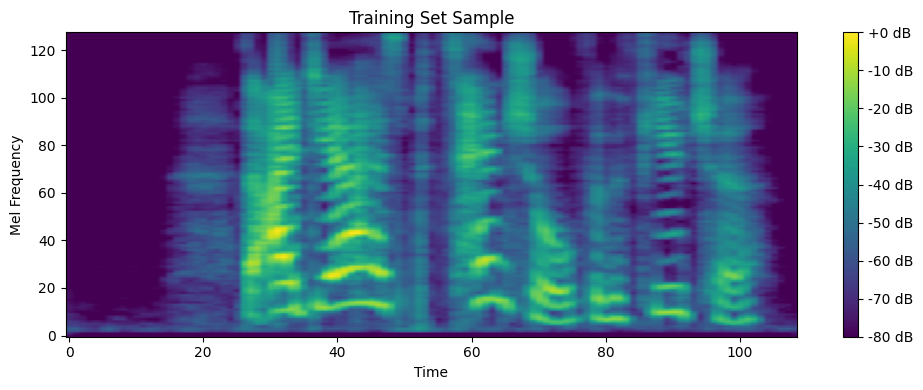

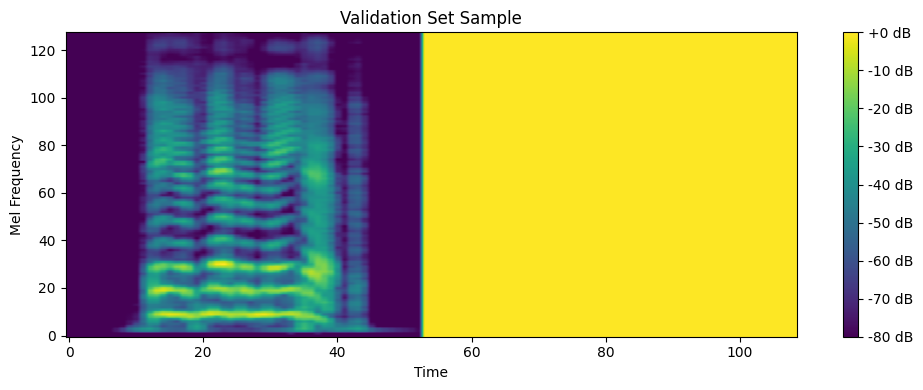

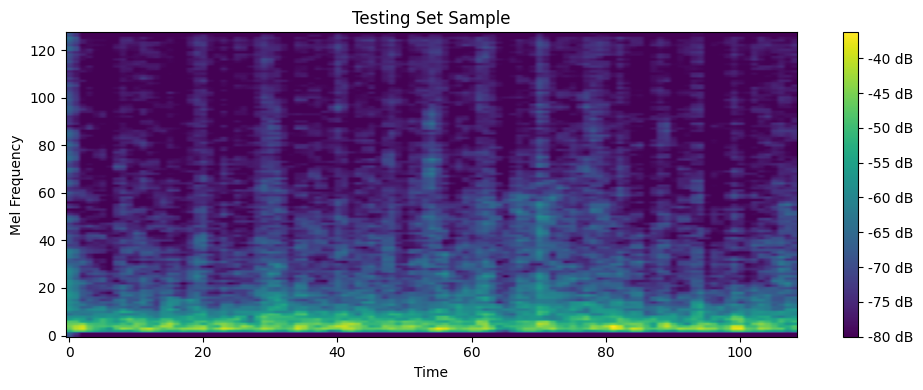

In [9]:
import matplotlib.pyplot as plt

# Function to plot a Mel spectrogram
def plot_mel_spectrogram(mel_spectrogram, title):
    """
    Plots a single Mel spectrogram.

    Args:
        mel_spectrogram (np.array): Mel spectrogram to plot.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

# Plot samples from training, validation, and testing sets
print("Plotting sample Mel spectrograms...")
plot_mel_spectrogram(X_train[0], "Training Set Sample")
plot_mel_spectrogram(X_val[0], "Validation Set Sample")
plot_mel_spectrogram(X_test[0], "Testing Set Sample")

### Section 3.3: One-Hot Encoding of Labels
This section encodes the integer labels (`bonafide` and `spoof`) into a one-hot format using the `to_categorical` function from Keras. This step prepares the labels for categorical classification tasks, aligning with the requirements of the categorical cross-entropy loss function. 

- **Input Example:** A label `0` becomes `[1, 0]`, and `1` becomes `[0, 1]`.
- **Consistency:** Encoding is applied to the training, validation, and test labels.

Key Benefits:
- Ensures compatibility with classification models.
- Simplifies the training process by providing a clear categorical representation of the labels.


In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Map labels from strings to integers
label_mapping = {"bonafide": 0, "spoof": 1}
y_train = np.array([label_mapping[label] for label in y_train])
y_val = np.array([label_mapping[label] for label in y_val])
y_test = np.array([label_mapping[label] for label in y_test])

# Convert integer labels to one-hot encoded format
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# 4. Define and train the CNN Model
### Section 4.1: Defining the CNN Model Architecture
This section defines a Convolutional Neural Network (CNN) designed for the classification of Mel spectrograms into `bonafide` and `spoof` classes. The architecture includes:

1. **Input Layer:**
   - Takes Mel spectrograms as input with a shape `(N_MELS, time_steps, 1)`.

2. **Convolutional Layers:**
   - Extract features using 32 and 64 filters with a kernel size of 3x3, applying ReLU activation for non-linear feature mapping.

3. **Pooling Layers:**
   - `MaxPooling2D` reduces the spatial size, making the network computationally efficient and summarizing important features.

4. **Fully Connected Layers:**
   - A `Dense` layer with 128 neurons captures global patterns, followed by a `Dropout` layer (50%) to prevent overfitting.
   - The final `Dense` layer with `NUM_CLASSES` neurons and `softmax` activation provides class probabilities.

5. **Model Compilation:**
   - **Optimizer:** Adam, known for adaptive learning rates.
   - **Loss Function:** Categorical Crossentropy for multi-class classification.
   - **Metric:** Accuracy to evaluate model performance.

This model is optimized for the task of detecting fake audio (spoof) from genuine audio (bonafide).


In [11]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)  # Input layer for the model

# First convolutional layer with 32 filters and ReLU activation
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)

# First max pooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second convolutional layer with 64 filters and ReLU activation
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)

# Second max pooling layer
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flattening the output from convolutional layers to prepare for dense layers
x = Flatten()(x)

# Fully connected dense layer with 128 neurons and ReLU activation
x = Dense(128, activation='relu')(x)

# Dropout layer to reduce overfitting by randomly setting 50% of inputs to zero
x = Dropout(0.5)(x)

# Output layer with softmax activation for multi-class classification
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the complete model
model = Model(inputs=model_input, outputs=model_output)

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Section 4.2 Train the model

In [12]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.6663 - loss: 17.9736 - val_accuracy: 0.7951 - val_loss: 0.3608
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8491 - loss: 0.3378 - val_accuracy: 0.8872 - val_loss: 0.2543
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8436 - loss: 0.3529 - val_accuracy: 0.8542 - val_loss: 0.3388
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9214 - loss: 0.2023 - val_accuracy: 0.9163 - val_loss: 0.1993
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9465 - loss: 0.1390 - val_accuracy: 0.9506 - val_loss: 0.1531
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9478 - loss: 0.1380 - val_accuracy: 0.8553 - val_loss: 0.3240
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9155 - loss: 0.1977 - val_accuracy: 0.9425 - val_loss: 0.1554
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9677 - loss: 0.0902 -

### Section 4.3: Saving the Model with Dynamic Filename
This section dynamically saves the trained model with a filename that includes the current date and time, ensuring each save operation generates a unique file. The filename is stored in the variable `model_filename` for future use. Example filename: `CNN_Model_20250117_153045.h5`.


In [13]:
from datetime import datetime

# Generate a dynamic filename with the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
model_filename = f"CNN_Model_{current_time}.h5"  # Dynamic model filename

# Save the model
model.save(model_filename)

print(f"Model saved as: {model_filename}")


Model saved as: CNN_Model_20250117_2221.h5


### Section 4.4: Visualizing the Model Architecture
This section generates a graphical representation of the CNN model architecture, including:
- **Layer Names:** Each layer's type and name.
- **Shapes:** Input and output tensor shapes for each layer, aiding in debugging and understanding the flow of data through the network.

The visualization is saved as `model_architecture.png` and displayed inline for easy reference. This graphical summary provides insights into the structure, depth, and connectivity of the model.


In [16]:
!pip install graphviz pydot

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plt.figure(figsize=(12, 8))
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)
img = plt.imread("model_architecture.png")
plt.imshow(img)
plt.axis('off')
plt.title("Model Architecture")
plt.show()

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_architecture.png'

<Figure size 1200x800 with 0 Axes>

# 5. Data Visualisation & Testing
### Section 5.1: Plotting Confusion Matrix and ROC Curve
This section evaluates the trained model on the training set by:
1. **Confusion Matrix:**
   - Displays a confusion matrix showing the counts of correctly and incorrectly classified samples for each class.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve to visualize the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR).
   - Computes and annotates the Area Under the Curve (AUC) score to measure the model's ability to discriminate between classes.

These visualizations help assess the performance of the model on the training dataset.


162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


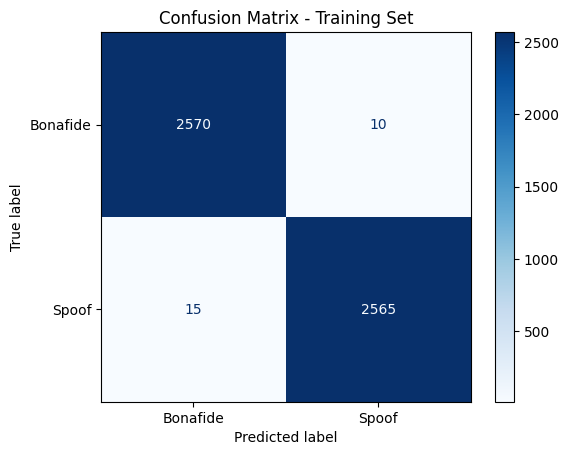

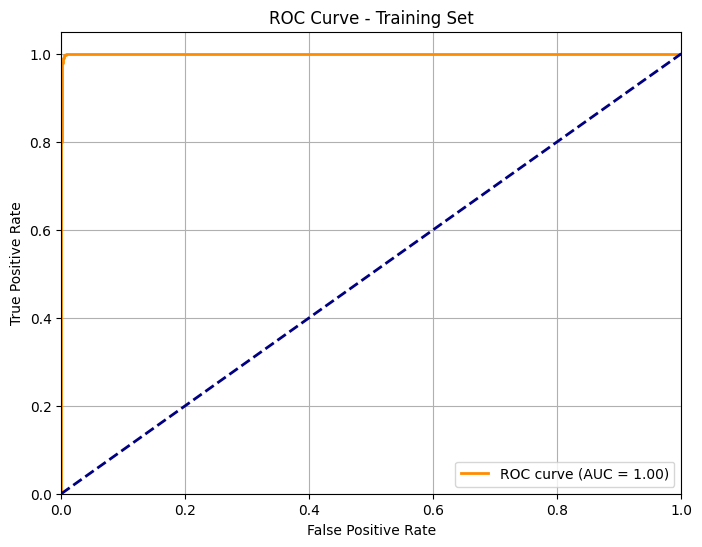

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# Load the saved model
model = load_model(model_filename)

# Predict on the training set
train_predictions = model.predict(X_train)
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(y_train, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Training Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(train_true_classes, train_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Section 5.2: Evaluation on the Validation Set
This section evaluates the trained model on the validation set using the following metrics:

1. **Confusion Matrix:**
   - Displays the confusion matrix, summarizing the number of correct and incorrect predictions for each class (`Bonafide` and `Spoof`).
   - Helps in understanding the model’s performance in terms of true positives, true negatives, false positives, and false negatives.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve, which visualizes the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.
   - Computes the Area Under the Curve (AUC) score to quantify the model’s classification performance.

3. **Precision-Recall Curve:**
   - Plots the Precision-Recall (PR) curve, which is particularly useful for imbalanced datasets.
   - Precision measures the proportion of true positives out of all positive predictions.
   - Recall (or sensitivity) measures the proportion of true positives out of all actual positives.
   - Computes the Average Precision (AP) score, which summarizes the PR curve into a single value.

These metrics provide a comprehensive evaluation of the model’s ability to distinguish between `Bonafide` and `Spoof` samples on unseen data, highlighting both its accuracy and robustness.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


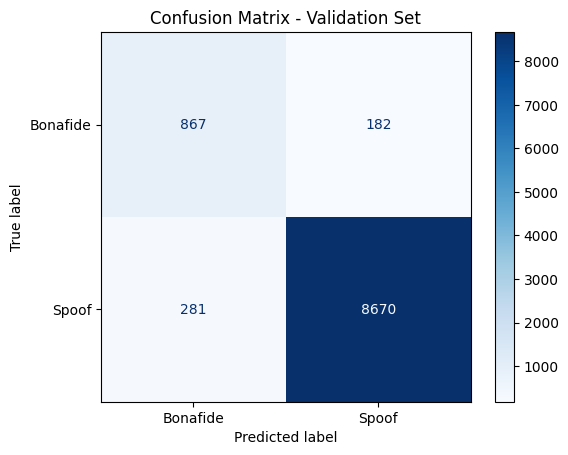

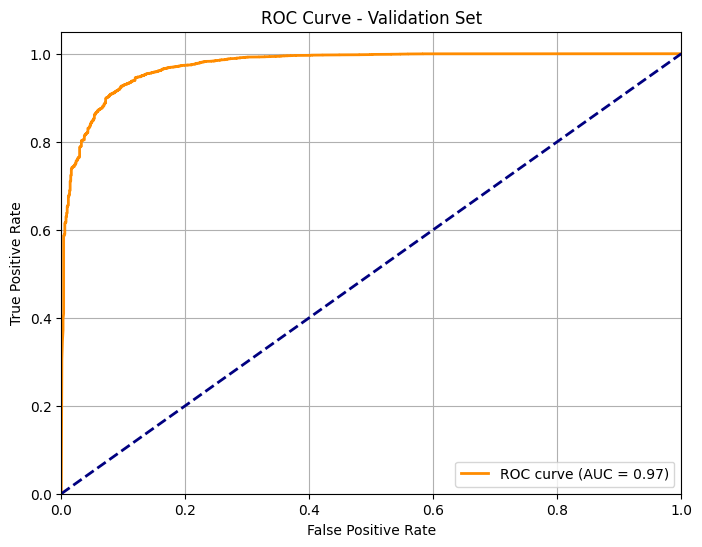

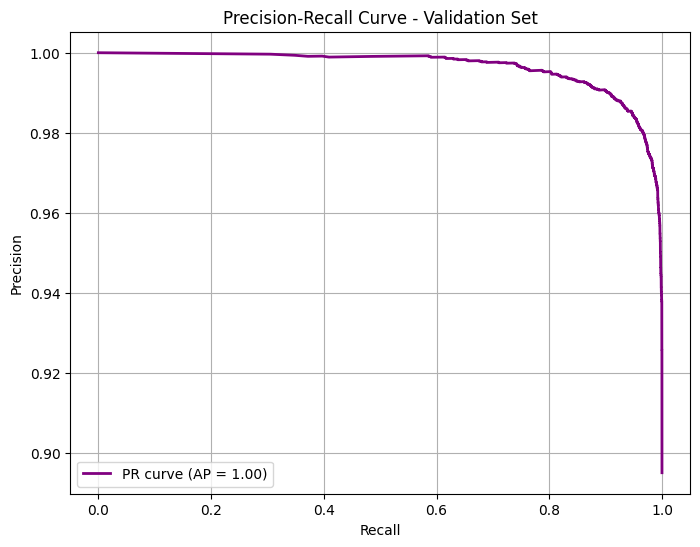

In [21]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict on the valing set
val_predictions = model.predict(X_val)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(val_true_classes, val_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(val_true_classes, val_predictions[:, 1])
average_precision = average_precision_score(val_true_classes, val_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Validation Set")
plt.legend(loc="lower left")
plt.grid()
plt.show()

### Section 5.2: Evaluation on the Testing Set
This section evaluates the trained model on the testing set using the following metrics:

1. **Confusion Matrix:**
   - Displays the confusion matrix, summarizing the number of correct and incorrect predictions for each class (`Bonafide` and `Spoof`).
   - Helps in understanding the model’s performance in terms of true positives, true negatives, false positives, and false negatives.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve, which visualizes the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.
   - Computes the Area Under the Curve (AUC) score to quantify the model’s classification performance.

3. **Precision-Recall Curve:**
   - Plots the Precision-Recall (PR) curve, which is particularly useful for imbalanced datasets.
   - Precision measures the proportion of true positives out of all positive predictions.
   - Recall (or sensitivity) measures the proportion of true positives out of all actual positives.
   - Computes the Average Precision (AP) score, which summarizes the PR curve into a single value.

These metrics provide a comprehensive evaluation of the model’s ability to distinguish between `Bonafide` and `Spoof` samples on unseen data, highlighting both its accuracy and robustness.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


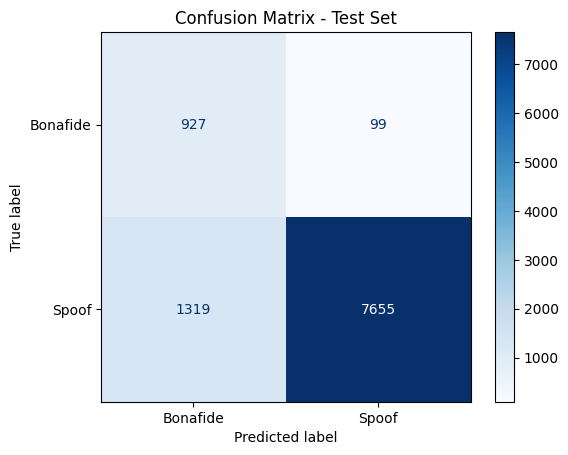

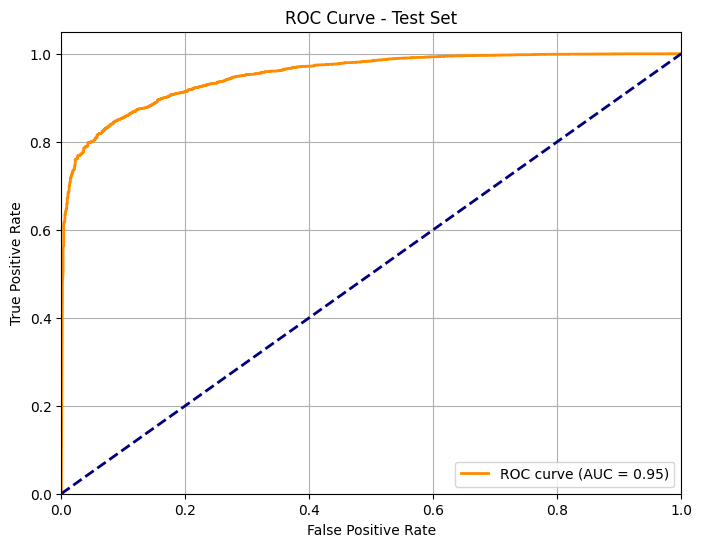

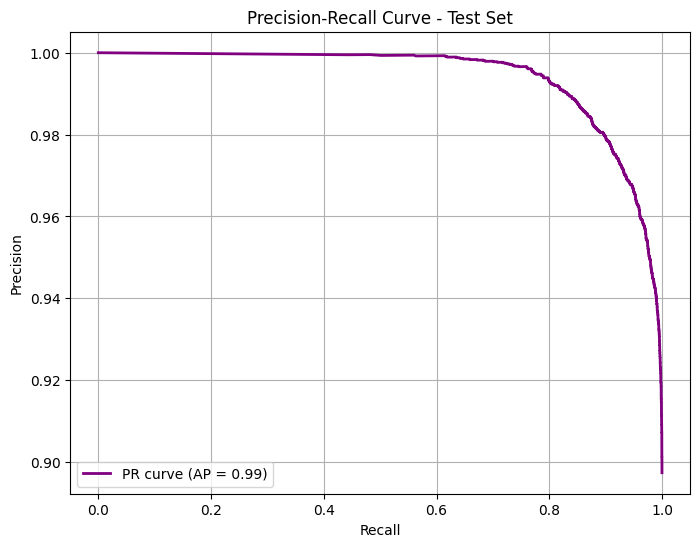

In [22]:
# Predict on the testing set
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_true_classes, test_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_true_classes, test_predictions[:, 1])
average_precision = average_precision_score(test_true_classes, test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# 6. Fairness Analisys
### Section 6.1: Load gender labels for validation and testing set

In [24]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_VAL_MALE = os.path.join(DATASET_PATH, "ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.dev.male.trl.txt")
LABELS_VAL_FEMALE = os.path.join(DATASET_PATH, "ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.dev.female.trl.txt")
LABELS_TEST_MALE = os.path.join(DATASET_PATH, "ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt")
LABELS_TEST_FEMALE = os.path.join(DATASET_PATH, "ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt")

# Define a function to load labels from the protocol file
def load_labels_fairness(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            if label == "target" or label == "nontarget":
                label = "bonafide"
            labels[filename] = label
    return labels

# Load training labels
val_male_labels = load_labels_fairness(LABELS_VAL_MALE)
val_female_labels = load_labels_fairness(LABELS_VAL_FEMALE)
test_male_labels = load_labels_fairness(LABELS_TEST_MALE)
test_female_labels = load_labels_fairness(LABELS_TEST_FEMALE)

# Print some examples
print("Number of validation samples with male voice:", len(val_male_labels))
print("Validation example label with male voice:", list(val_male_labels.items())[:5])
print("Number of validation samples with female voice:", len(val_female_labels))
print("Validation example label with female voice:", list(val_female_labels.items())[:5])
print("Number of testing samples with male voice:", len(test_male_labels))
print("Testing example label with male voice:", list(test_male_labels.items())[:5])
print("Number of testing samples with female voice:", len(test_female_labels))
print("Testing example label with female voice:", list(test_female_labels.items())[:5])

Number of validation samples with male voice: 8260
Validation example label with male voice: [('LA_D_4004968', 'bonafide'), ('LA_D_6027798', 'bonafide'), ('LA_D_3986002', 'bonafide'), ('LA_D_9330492', 'bonafide'), ('LA_D_1364611', 'bonafide')]
Number of validation samples with female voice: 16584
Validation example label with female voice: [('LA_D_4356541', 'bonafide'), ('LA_D_6092752', 'bonafide'), ('LA_D_5090421', 'bonafide'), ('LA_D_6718237', 'bonafide'), ('LA_D_6073354', 'bonafide')]
Number of testing samples with male voice: 21939
Testing example label with male voice: [('LA_E_1103494', 'bonafide'), ('LA_E_4861467', 'bonafide'), ('LA_E_6229989', 'bonafide'), ('LA_E_4483232', 'bonafide'), ('LA_E_3110493', 'bonafide')]
Number of testing samples with female voice: 49298
Testing example label with female voice: [('LA_E_9185691', 'bonafide'), ('LA_E_2470053', 'bonafide'), ('LA_E_4685529', 'bonafide'), ('LA_E_8330665', 'bonafide'), ('LA_E_7828150', 'bonafide')]


### Section 6.2: Recuce quantity of data

In [25]:
# ATTENTION: Dataset limiting --------------------------------
val_male_labels_trimmed = shuffle_and_trim_dict(val_male_labels, n=5000)
val_female_labels_trimmed = shuffle_and_trim_dict(val_female_labels, n=5000)
test_male_labels_trimmed = shuffle_and_trim_dict(test_male_labels, n=5000)
test_female_labels_trimmed = shuffle_and_trim_dict(test_female_labels, n=5000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of validation samples with male voice:", len(val_male_labels_trimmed))
print("Validation example label with male voice:", list(val_male_labels_trimmed.items())[:5])
print("Number of validation samples with female voice:", len(val_female_labels_trimmed))
print("Validation example label with female voice:", list(val_female_labels_trimmed.items())[:5])
print("Number of testing samples with male voice:", len(test_male_labels_trimmed))
print("Testing example label with male voice:", list(test_male_labels_trimmed.items())[:5])
print("Number of testing samples with female voice:", len(test_female_labels_trimmed))
print("Testing example label with female voice:", list(test_female_labels_trimmed.items())[:5])

Number of validation samples with male voice: 5000
Validation example label with male voice: [('LA_D_6435177', 'spoof'), ('LA_D_5169731', 'spoof'), ('LA_D_7579833', 'spoof'), ('LA_D_5005167', 'spoof'), ('LA_D_2648488', 'spoof')]
Number of validation samples with female voice: 5000
Validation example label with female voice: [('LA_D_4123062', 'spoof'), ('LA_D_8854126', 'spoof'), ('LA_D_6830532', 'spoof'), ('LA_D_5084936', 'spoof'), ('LA_D_4790022', 'spoof')]
Number of testing samples with male voice: 5000
Testing example label with male voice: [('LA_E_2650255', 'spoof'), ('LA_E_7047716', 'spoof'), ('LA_E_7390922', 'spoof'), ('LA_E_6899888', 'spoof'), ('LA_E_2305557', 'spoof')]
Number of testing samples with female voice: 5000
Testing example label with female voice: [('LA_E_1727087', 'bonafide'), ('LA_E_9995209', 'spoof'), ('LA_E_2426575', 'spoof'), ('LA_E_9166326', 'spoof'), ('LA_E_4436946', 'spoof')]


### Section 6.3: Load files of each dataset

In [26]:
# Load the datasets
print("Loading validation dataset with male voices...")
X_val_male, y_val_male = load_dataset_files(DATASET_VAL, val_male_labels_trimmed)
print("Loading validation dataset with female voices...")
X_val_female, y_val_female = load_dataset_files(DATASET_VAL, val_female_labels_trimmed)
print("Loading testing dataset with male voices...")
X_test_male, y_test_male = load_dataset_files(DATASET_TEST, test_male_labels_trimmed)
print("Loading testing dataset with female voices...")
X_test_female, y_test_female = load_dataset_files(DATASET_TEST, test_female_labels_trimmed)

# Verify shapes
print(f"Validation data (male voices) shape: {X_val_male.shape}, Labels shape: {y_val_male.shape}")
print(f"Validation data (female voices) shape: {X_val_female.shape}, Labels shape: {y_val_female.shape}")
print(f"Testing data (male voices) shape: {X_test_male.shape}, Labels shape: {y_test_male.shape}")
print(f"Testing data (female voices) shape: {X_test_female.shape}, Labels shape: {y_test_female.shape}")

Loading validation dataset with male voices...


Loading and converting files: 100%|█████████████████████████████████████████████████| 5000/5000 [01:41<00:00, 49.04it/s]


Loading validation dataset with female voices...


Loading and converting files: 100%|█████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.30it/s]


Loading testing dataset with male voices...


Loading and converting files: 100%|█████████████████████████████████████████████████| 5000/5000 [01:36<00:00, 51.71it/s]


Loading testing dataset with female voices...


Loading and converting files: 100%|█████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.70it/s]


Validation data (male voices) shape: (5000, 128, 109), Labels shape: (5000,)
Validation data (female voices) shape: (5000, 128, 109), Labels shape: (5000,)
Testing data (male voices) shape: (5000, 128, 109), Labels shape: (5000,)
Testing data (female voices) shape: (5000, 128, 109), Labels shape: (5000,)


### Section 6.4: Labels preprocessing

In [27]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Map labels from strings to integers
label_mapping = {"bonafide": 0, "spoof": 1}
y_val_male = np.array([label_mapping[label] for label in y_val_male])
y_val_female = np.array([label_mapping[label] for label in y_val_female])
y_test_male = np.array([label_mapping[label] for label in y_test_male])
y_test_female = np.array([label_mapping[label] for label in y_test_female])

# Convert integer labels to one-hot encoded format
y_train = to_categorical(y_val_male, NUM_CLASSES)
y_val = to_categorical(y_val_female, NUM_CLASSES)
y_test = to_categorical(y_test_male, NUM_CLASSES)
y_test = to_categorical(y_test_female, NUM_CLASSES)

### Section 6.5: Fairness Analysis for Gender-Based Prediction on Validation

In this section, the model is evaluated separately on validation datasets for male and female voices to assess prediction accuracy and fairness. The following steps are performed:

1. **Prediction:**
   - The model generates predictions for `X_val_male` and `X_val_female`.

2. **Confusion Matrices:**
   - Confusion matrices for male and female datasets are plotted to visualize the performance in terms of true positives, false positives, true negatives, and false negatives.

3. **ROC Curves:**
   - Separate ROC curves are plotted for male and female datasets.
   - The Area Under the Curve (AUC) score is calculated for both genders to quantify the model's ability to distinguish between bonafide and spoof samples.

4. **Accuracy Comparison:**
   - The accuracy for male and female datasets is computed and displayed as a bar chart, highlighting any disparity in performance.

This analysis helps identify potential biases in the model related to speaker gender.


Predicting on validation dataset with male voices...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Predicting on validation dataset with female voices...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


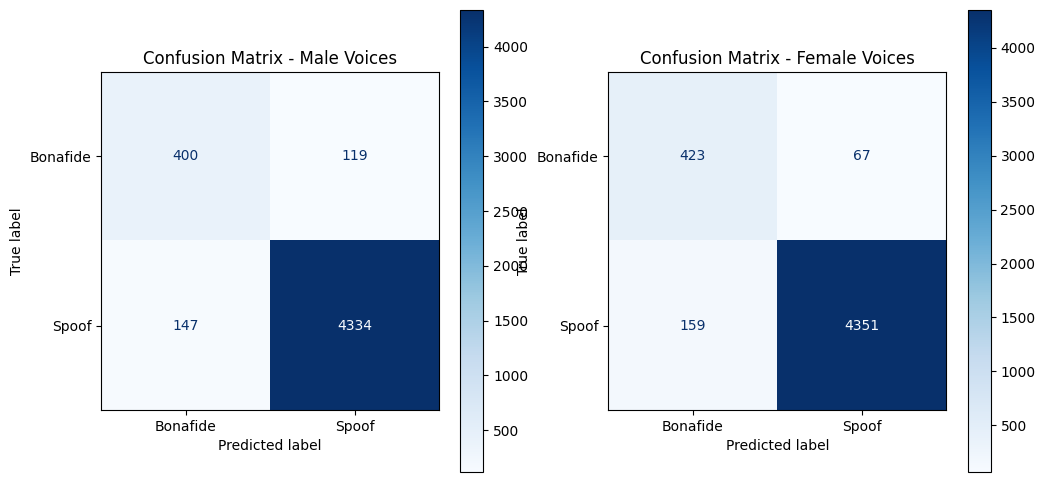

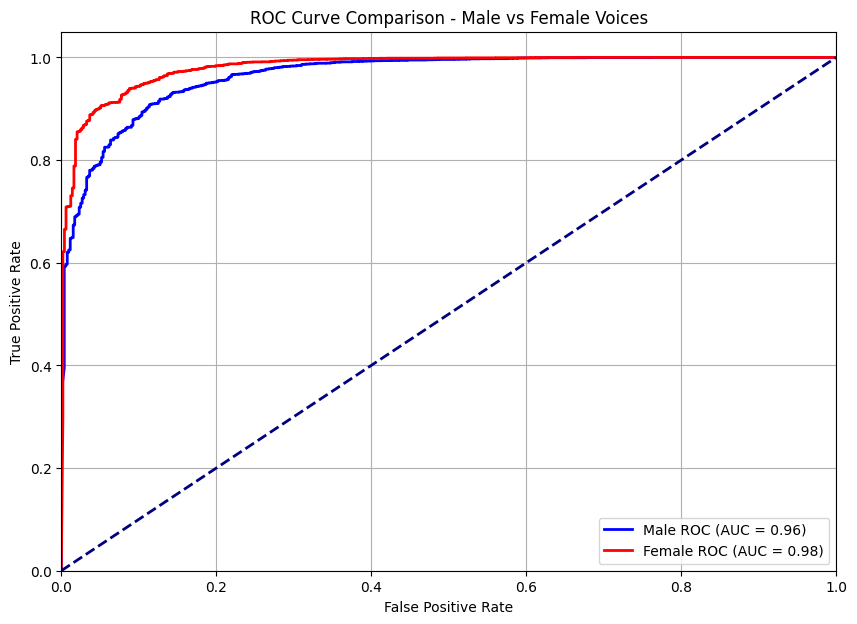

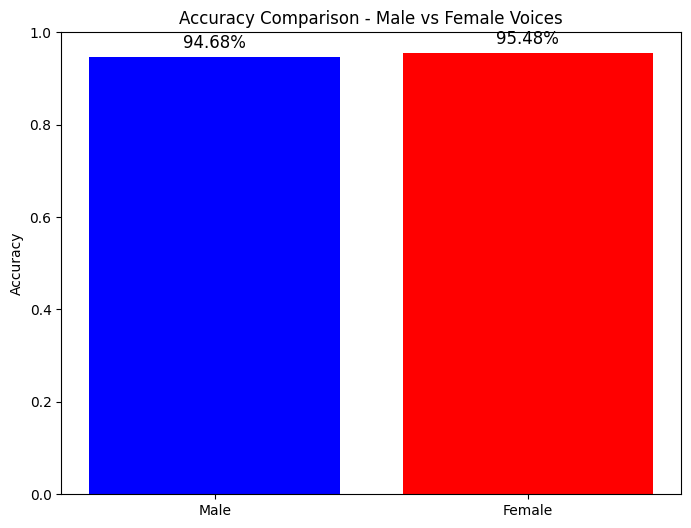

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# Predict on validation datasets
print("Predicting on validation dataset with male voices...")
val_male_predictions = model.predict(X_val_male)
val_male_pred_classes = np.argmax(val_male_predictions, axis=1)  # Predicted classes
val_male_true_classes = y_val_male  # True classes already in integer form

print("Predicting on validation dataset with female voices...")
val_female_predictions = model.predict(X_val_female)
val_female_pred_classes = np.argmax(val_female_predictions, axis=1)  # Predicted classes
val_female_true_classes = y_val_female  # True classes already in integer form

# Confusion Matrices
conf_matrix_male = confusion_matrix(val_male_true_classes, val_male_pred_classes)
conf_matrix_female = confusion_matrix(val_female_true_classes, val_female_pred_classes)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(conf_matrix_male, display_labels=["Bonafide", "Spoof"]).plot(ax=ax[0], cmap="Blues")
ax[0].set_title("Confusion Matrix - Male Voices")
ConfusionMatrixDisplay(conf_matrix_female, display_labels=["Bonafide", "Spoof"]).plot(ax=ax[1], cmap="Blues")
ax[1].set_title("Confusion Matrix - Female Voices")
plt.show()

# ROC Curves
fpr_male, tpr_male, _ = roc_curve(val_male_true_classes, val_male_predictions[:, 1])  # Use the positive class probabilities
roc_auc_male = auc(fpr_male, tpr_male)

fpr_female, tpr_female, _ = roc_curve(val_female_true_classes, val_female_predictions[:, 1])  # Use the positive class probabilities
roc_auc_female = auc(fpr_female, tpr_female)

plt.figure(figsize=(10, 7))
plt.plot(fpr_male, tpr_male, color='blue', lw=2, label=f"Male ROC (AUC = {roc_auc_male:.2f})")
plt.plot(fpr_female, tpr_female, color='red', lw=2, label=f"Female ROC (AUC = {roc_auc_female:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Male vs Female Voices")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Summary Plot
accuracy_male = np.mean(val_male_pred_classes == val_male_true_classes)
accuracy_female = np.mean(val_female_pred_classes == val_female_true_classes)

plt.figure(figsize=(8, 6))
plt.bar(["Male", "Female"], [accuracy_male, accuracy_female], color=['blue', 'red'])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison - Male vs Female Voices")
for i, v in enumerate([accuracy_male, accuracy_female]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=12)
plt.show()

### Section 6.6: Fairness Analysis for Gender-Based Prediction on Testing

In this section, the model is evaluated separately on test datasets for male and female voices to assess prediction accuracy and fairness. The following steps are performed:

1. **Prediction:**
   - The model generates predictions for `X_test_male` and `X_test_female`.

2. **Confusion Matrices:**
   - Confusion matrices for male and female datasets are plotted to visualize the performance in terms of true positives, false positives, true negatives, and false negatives.

3. **ROC Curves:**
   - Separate ROC curves are plotted for male and female datasets.
   - The Area Under the Curve (AUC) score is calculated for both genders to quantify the model's ability to distinguish between bonafide and spoof samples.

4. **Accuracy Comparison:**
   - The accuracy for male and female datasets is computed and displayed as a bar chart, highlighting any disparity in performance.

This analysis helps identify potential biases in the model related to speaker gender.

Predicting on test dataset with male voices...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Predicting on test dataset with female voices...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


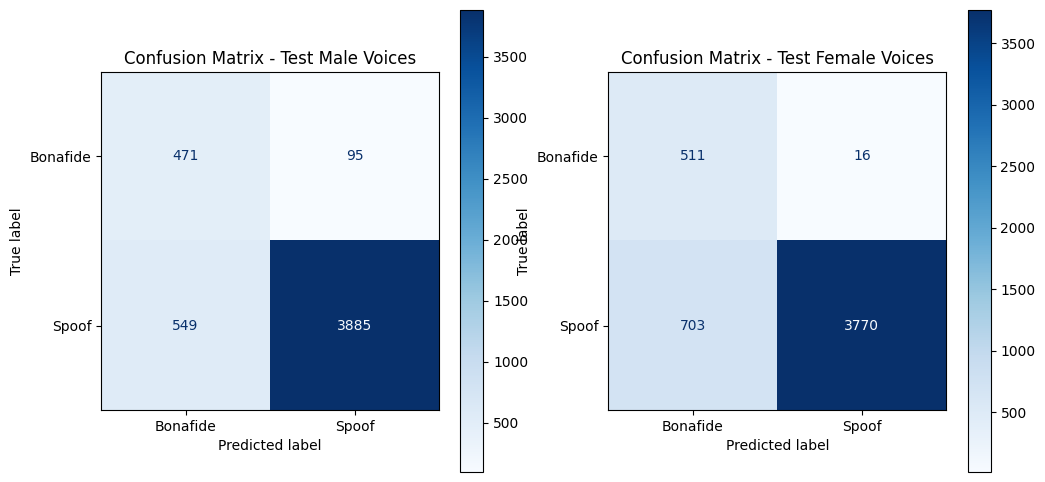

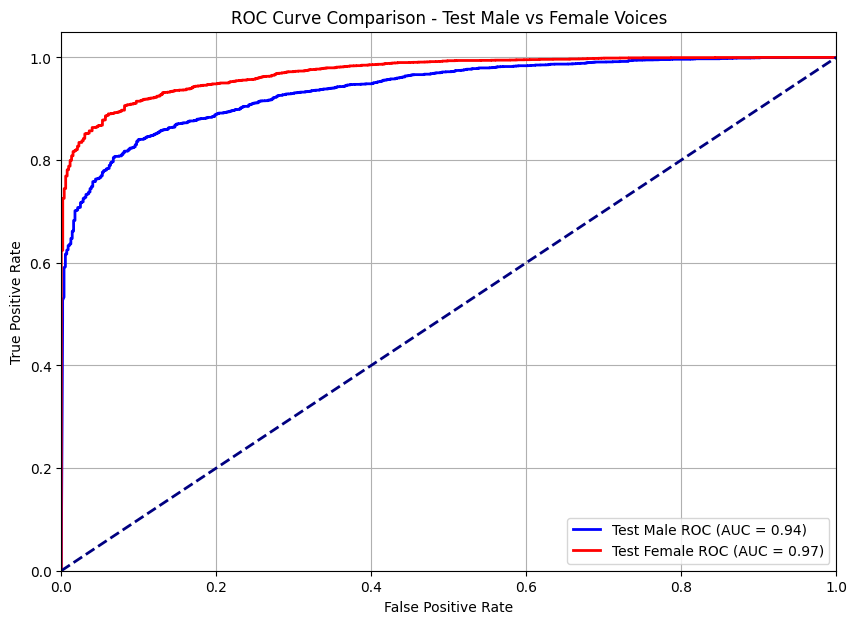

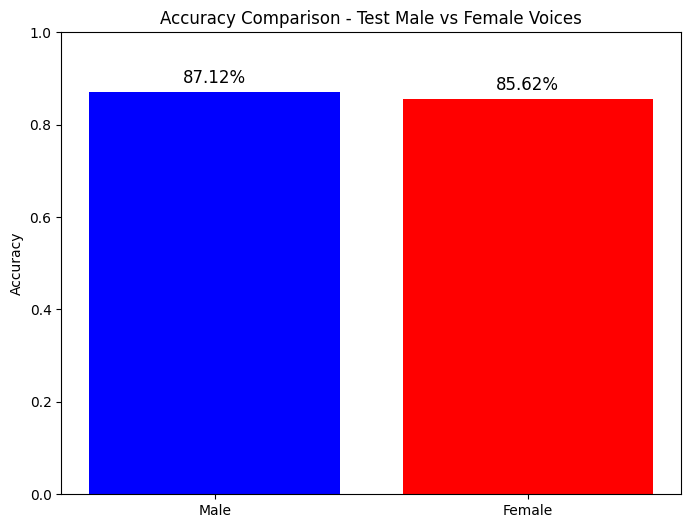

In [34]:
print("Predicting on test dataset with male voices...")
test_male_predictions = model.predict(X_test_male)
test_male_pred_classes = np.argmax(test_male_predictions, axis=1)  # Predicted classes
test_male_true_classes = y_test_male  # True classes already in integer form

print("Predicting on test dataset with female voices...")
test_female_predictions = model.predict(X_test_female)
test_female_pred_classes = np.argmax(test_female_predictions, axis=1)  # Predicted classes
test_female_true_classes = y_test_female  # True classes already in integer form

# Confusion Matrices
conf_matrix_test_male = confusion_matrix(test_male_true_classes, test_male_pred_classes)
conf_matrix_test_female = confusion_matrix(test_female_true_classes, test_female_pred_classes)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(conf_matrix_test_male, display_labels=["Bonafide", "Spoof"]).plot(ax=ax[0], cmap="Blues")
ax[0].set_title("Confusion Matrix - Test Male Voices")
ConfusionMatrixDisplay(conf_matrix_test_female, display_labels=["Bonafide", "Spoof"]).plot(ax=ax[1], cmap="Blues")
ax[1].set_title("Confusion Matrix - Test Female Voices")
plt.show()

# ROC Curves
fpr_test_male, tpr_test_male, _ = roc_curve(test_male_true_classes, test_male_predictions[:, 1])
roc_auc_test_male = auc(fpr_test_male, tpr_test_male)

fpr_test_female, tpr_test_female, _ = roc_curve(test_female_true_classes, test_female_predictions[:, 1])
roc_auc_test_female = auc(fpr_test_female, tpr_test_female)

plt.figure(figsize=(10, 7))
plt.plot(fpr_test_male, tpr_test_male, color='blue', lw=2, label=f"Test Male ROC (AUC = {roc_auc_test_male:.2f})")
plt.plot(fpr_test_female, tpr_test_female, color='red', lw=2, label=f"Test Female ROC (AUC = {roc_auc_test_female:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Test Male vs Female Voices")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Summary Plot
accuracy_test_male = np.mean(test_male_pred_classes == test_male_true_classes)
accuracy_test_female = np.mean(test_female_pred_classes == test_female_true_classes)

plt.figure(figsize=(8, 6))
plt.bar(["Male", "Female"], [accuracy_test_male, accuracy_test_female], color=['blue', 'red'])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison - Test Male vs Female Voices")
for i, v in enumerate([accuracy_test_male, accuracy_test_female]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=12)
plt.show()
